# Multiple testing - the blessing of dimensionality

## Background

In the previous notebook, we saw that testing for a causal interaction $X\to Y$ (using an instrumental variable $Z$) requires combining evidence from mulitple hypothesis tests. In that notebook, we basically eye-balled the p-values and gave thumbs-up or thumbs-down for a causal relation. Not only is this practically infeasible when testing causality between ten-thousands of pairs in omics data, we would also like to quantify the statistical significance and uncertainty of each finding. This turns out to be a non-trivial question, because:

- Both the sufficient and necessary condition are *combinations* of statistical tests.
- The necessary condition includes a test where *accepting* the null hypothesis is a *positive* finding, but a non-sificgniatp``-value (no evidence for rejecting the null hypothesis) does not imply significant evidence against the alternative hypothesisThe aim of this notebook is to explain how we go from classical hypothesis tests to expressing the probability of a model being true, by exploiting that we are testing thousands of genes at once, that is by exploiting the blessing of dimensionay!lit

## Setup the environment

In [5]:
using DrWatson
quickactivate(@__DIR__)

In [140]:
using DataFrames
using Arrow
using Distributions
using GLM
using Gadfly
using Compose
using Random
using BioFindr

## Load data

This tutorial uses [preprocessed data files](https://github.com/lingfeiwang/findr-data-geuvadis) from the [GEUVADIS study](https://doi.org/10.1038/nature12531). In particular, we use genotype and mRNA expression data from the same set of samples:


In [131]:
dgt = DataFrame(Arrow.Table(datadir("processed","findr-data-geuvadis", "dgt.arrow")));
dt = DataFrame(Arrow.Table(datadir("processed","findr-data-geuvadis", "dt.arrow")));

We apply an [inverse normal transformation](https://lab.michoel.info/BioFindr.jl/stable/inference/#BioFindr.supernormalize) such that the expression profiles of all genes are normally distributed:

In [36]:
Yt = BioFindr.supernormalize(dt);

The [preprocessed GEUVADIS data](https://github.com/lingfeiwang/findr-data-geuvadis) has been organized such that each column of the genotype data is the strongest eQTLs for the corresponding column in the matching expression data. Usually however, eQTL mapping data will be available in the form of a table with variant IDs, gene IDs, and various eQTL associaion statistics (see the [original GEUVADIS file](https://www.ebi.ac.uk/biostudies/files/E-GEUV-1/E-GEUV-1/analysis_results/EUR373.gene.cis.FDR5.all.rs137.txt.gz) for an example). Let's artificially create such tables for our data:

In [33]:
dpt = DataFrame(SNP_ID = names(dgt), GENE_ID=names(dt)[1:ncol(dgt)]);

In this analysis we will use one SNP as an instrumental variable $Z$ and test the association $Z\to Y$ for all genes $Y$. Here's a good example SNP to use:

In [56]:
snp_name = "rs6504337";
snp_id = findfirst(names(dgt) .== snp_name);
Z =dgt[:,snp_id];

For later use, we also store the gene for which this SNP is an eQTL:

In [132]:
gene_name = dpt[findfirst(dpt.SNP_ID .== snp_name),2];
gene_id = findfirst(names(dt) .== gene_name);

Lastly, we need the number of samples in our data and the number of unique genotypes in $Z$:

In [133]:
ns = length(Z);
ng = length(unique(Z));

In [142]:
Random.seed!(123);
Z_rand = shuffle(Z);

## P-value refresher

Recall that in statistical hypothesis testing, we have a null hypothesis $H_0$ and an alternative hypothesis $H_1$. For instance, if we test the association between $Z$ and $Y$, the null hypothesis is that there is no association and the alternative that there is an association. To quantify evidence for or against the null hypothesis, we need a *test static*. In the [BioFindr](https://github.com/tmichoel/BioFindr.jl) software all hypothesis tests are [likelihood ratio tests](https://en.wikipedia.org/wiki/Likelihood-ratio_test), and the test statistics are *log-likelihood ratios (LLRs).* The null distribution of these LLRs are [known analytically](https://lab.michoel.info/BioFindr.jl/stable/randomLLR/).

The [p-value](https://en.wikipedia.org/wiki/P-value) is defined as the probability of obtaining test results at least as extreme as the result actually observed under the assumption that the null hypothesis is correct. In other words, if we observe $LLR=x$, then

$$
\text{p-value}(x) = P(LLR\geq x \mid H_0)
$$

Let's compute the LLRs and their p-values under the null hypothesis for the association or *"linkage"* test $Z\to Y$:

In [134]:
llr = BioFindr.realLLR_col(Yt,Z);
pnull = BioFindr.nullpval(llr,ns,ng,:link);

We can do the same for the randomly shuffled $Z$:

In [143]:
llr_rand = BioFindr.realLLR_col(Yt,Z_rand);
pnull_rand = BioFindr.nullpval(llr_rand,ns,ng,:link);

An important property of p-values is that under the null hypothesis, p-values are uniformly distribution. We can verify this by plotting the histogram of p-values for the randomly shuffled instruments (left histogram). By contrast the observed distribution in the real data shows an inflation of small p-values. 

<div style="background-color:LightYellow; color:black">
<h3>Exercise</h3> 
     What does the inflation of small p-values mean? Read <a href="http://varianceexplained.org/statistics/interpreting-pvalue-histogram/">how to interpret p-value histograms</a> for clues!
</div>

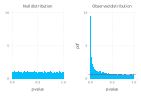

In [159]:
hist = layer(x=pnull, Geom.histogram(density=true))
hl = layer(x=0.:0.1:1.,yintercept=[π0], Geom.hline(color="red"))
p1 = plot(hl, hist, Guide.xlabel("p-value", orientation=:horizontal), Guide.ylabel("pdf"), Guide.title("Observed distribution"))
p2 = plot(x=pnull_rand, Geom.histogram(density=true), Guide.xlabel("p-value", orientation=:horizontal), Coord.cartesian(; ymax=10), Guide.title("Null distribution"))
hstack(p2,p1)

## Bayes theorem and model probabilities

A p-value gives a probability of observing a test statistic assuming a certain model (the null model) is true. In model selection, we are interested in the opposite: the probability that a model (or hypothesis) is true given the observed test statistic. The relation between those two is given by Bayes's theorem:

$$
P(H_0 = \text{true} \mid LLR= x ) = \frac{p(LLR= x\mid H_0)P(H_0 = \text{true})}{p(LLR= x)} = 1 - P(H_1 = \text{true} \mid LLR= x )
$$

In this expression:

- $p(LLR=x\mid H_0)$ is the null distribution of the LLR test statistic
- $P(H_0 = \text{true})$ is the prior probability of observing the null model
- $p(LLR= x)$ is the observed distribution of the LLR test statistic

In [88]:
pp, dmix = BioFindr.fit_mixdist_mom(llr, ns, ng, :link);

In [73]:
π0 = BioFindr.pi0est(pnull)

0.6078745468341623

In [90]:
dnull = BioFindr.nulldist(ns,ng,:link)

BioFindr.LBeta(α=1.0, β=358.0)

In [136]:
lval = range(0.,maximum(llr),500);
pdf_null = π0 * pdf.(dnull,lval);
pdf_real = pdf.(dmix,lval);
prob = 1 .- prob_null ./ prob_real;

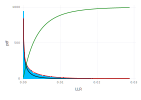

In [138]:
hist = layer(x=llr, Geom.histogram(density=true))
line_real = layer(p,x=lval, y=pdf_real, Geom.line, color=[colorant"red"],Theme(line_width=1.5pt))
line_null = layer(p,x=lval, y=pdf_null, Geom.line, color=[colorant"black"],Theme(line_width=1.5pt))
line_prob = layer(p,x=lval, y=1e3*prob, Geom.line, color=[colorant"green"],Theme(line_width=1.5pt))
plot(line_prob,line_real,line_null,hist,Guide.xlabel("LLR", orientation=:horizontal),Guide.ylabel("pdf"))
#vstack(p1,p2)